<a href="https://colab.research.google.com/github/amys4932/Deep-learning/blob/main/project/DL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# phase 0

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import cv2
import numpy as np
import dlib
from PIL import Image

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/Deep_learning/project
%ls

/content/gdrive/MyDrive/Deep_learning/project
dev/     DL_project.ipynb  MSCTD/  test.zip     train_ende.zip
dev.zip  features.npy      test/   train_ende/


In [ ]:
# download the dataset to drive
!git clone https://github.com/XL2248/MSCTD

fatal: destination path 'MSCTD' already exists and is not an empty directory.


In [ ]:
!pip -q install --upgrade --no-cache-dir gdown

In [ ]:
!gdown --id 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj   #train
!gdown --id 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W   #test
!gdown --id 12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA   #dev


/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj 

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com

In [ ]:
# add a shortcut of image data to drive then run below code.

!unzip train_ende.zip
!unzip test.zip
!unzip dev.zip

Archive:  train_ende.zip
replace train_ende/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test.zip
replace test/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  dev.zip
replace dev/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# MSCTDDataset

In [7]:
class MSCTDDataset(Dataset):
    def __init__(self, text_dir, image_index_dir, sentiment_dir, img_dir, transform=None):

        self.transform = transform
        self.img_dir = img_dir

        # load english texts
        with open(text_dir) as file:
            self.text = [line.rstrip() for line in file]

        # load conversation data
        with open(image_index_dir) as file:
            self.img_index = [list(map(int, line.rstrip()[1:-1].split(','))) for line in file]
            self.first_index = np.asarray([self.img_index[i][0] for i in range(self.img_index.__len__())])
            self.conversation_length = np.asarray([len(self.img_index[i]) for i in range(len(self.img_index))])

        # load sentiment of each text
        with open(sentiment_dir) as file:
            self.sentiment = np.asarray([int(line.rstrip()) for line in file])


    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        print(idx)

        n_conversation = (self.first_index <= idx).sum()-1 # this idx belongs to which conversation (0,1,2,3,...)
        conversation_length = self.conversation_length[n_conversation]
        # sentiment_pattern = self.sentiment[self.first_index[n_conversation]: self.first_index[n_conversation+1]]

        image = Image.open(self.img_dir+'/'+str(idx)+'.jpg')
        if self.transform:
            image = self.transform(image)

        return self.text[idx], n_conversation, self.sentiment[idx], image, conversation_length



train_transform = transforms.Compose([
    transforms.Resize((300,600)),
    transforms.ToTensor()])

train_data = MSCTDDataset('MSCTD/MSCTD_data/ende/english_train.txt',
                          'MSCTD/MSCTD_data/ende/image_index_train.txt',
                          'MSCTD/MSCTD_data/ende/sentiment_train.txt',
                          'train_ende',
                          transform=train_transform)
test_data = MSCTDDataset('MSCTD/MSCTD_data/ende/english_test.txt',
                          'MSCTD/MSCTD_data/ende/image_index_test.txt',
                          'MSCTD/MSCTD_data/ende/sentiment_test.txt',
                          'test',
                          transform=train_transform)

train_dataloader = DataLoader(train_data, batch_size=100, num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=100, num_workers=1)

# Data Analysis

In [ ]:
!pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=8b4aea82ed7aa50beee8341857504e190c5b511a09cd0fe9b8d7a06fe788fbee
  Stored in directory: /root/.cache/pip/wheels/b4/4b/8f/751e99d45f089bdf366a7d3e5066db3c2b84a62e4377f534d7
Successfully built face-recognition-models


In [8]:
import face_recognition


sentiment = train_data.sentiment
length = np.array([train_data.text[k].split().__len__() for k in range(len(train_data.text))])
conversation_length = train_data.conversation_length
n_face = []


for (t1, n_conversation, sent, img, cl) in train_dataloader:
  # print(t1)
  for k in range(img.shape[0]):

    image = np.array(transforms.ToPILImage()(img[k,:,:,:])) 
    
    face_locations = face_recognition.face_locations(image)
    n_face.append(len(face_locations))
    print(face_locations, image.shape)

n_face = np.asarray(n_face)


Streaming output truncated to the last 5000 lines.
17867
17868
[(63, 378, 138, 303)] (300, 600, 3)
17869
17870
17871
17872
17873
[(68, 489, 291, 266)] (300, 600, 3)
17874
17875
17876
17877
17878
[(66, 315, 156, 225)] (300, 600, 3)
[(56, 330, 163, 223)] (300, 600, 3)
17879
17880
17881
17882
17883
17884
17885
17886
17887
[] (300, 600, 3)
17888
17889
17890
17891
17892
17893[(56, 330, 163, 223)] (300, 600, 3)

17894
17895
17896
17897
[] (300, 600, 3)
17898
17899
[(43, 365, 266, 142)] (300, 600, 3)
[(57, 448, 242, 262)] (300, 600, 3)
[(19, 365, 242, 142)] (300, 600, 3)
[(44, 342, 152, 235)] (300, 600, 3)
[] (300, 600, 3)
[] (300, 600, 3)
[] (300, 600, 3)
[] (300, 600, 3)
[(26, 321, 62, 285)] (300, 600, 3)
[(64, 304, 219, 150)] (300, 600, 3)
[(44, 378, 152, 270)] (300, 600, 3)
[] (300, 600, 3)
[(128, 366, 235, 259)] (300, 600, 3)
[] (300, 600, 3)
[] (300, 600, 3)
[] (300, 600, 3)
[(43, 489, 266, 266)] (300, 600, 3)
[(38, 377, 90, 325)] (300, 600, 3)
[] (300, 600, 3)
[(39, 368, 168, 239)] (30

In [19]:
print(sentiment, length, n_face, conversation_length)
print(sentiment.shape, length.shape, n_face.shape, conversation_length.shape)

[0 0 1 ... 0 2 1] [ 3 10  8 ... 10  8  2] [1 0 1 ... 2 1 1] [ 5  5  7 ... 13  7  7]
(20240,) (20240,) (20240,) (2066,)


In [10]:
# save extracted features
with open('features.npy', 'wb') as f:
    np.save(f, sentiment)
    np.save(f, length)
    np.save(f, n_face)
    np.save(f, conversation_length)

In [11]:
# load the features
with open('features.npy', 'rb') as f:
    sentiment = np.load(f)
    length = np.load(f)
    n_face = np.load(f)
    conversation_length = np.load(f)

print(sentiment, length, n_face, conversation_length)

[0 0 1 ... 0 2 1] [ 3 10  8 ... 10  8  2] [1 0 1 ... 2 1 1] [ 5  5  7 ... 13  7  7]


# results

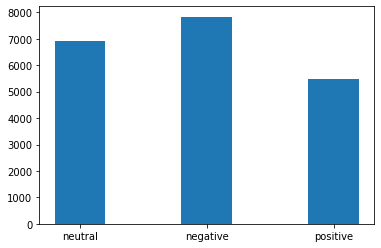

In [13]:
# sentiment priory distribution
hist = np.histogram(sentiment, 3)
plt.bar(['neutral','negative','positive'], hist[0], width = 0.4)
plt.show()

# the classes are imbalanced and we should consider this fact in our model design.

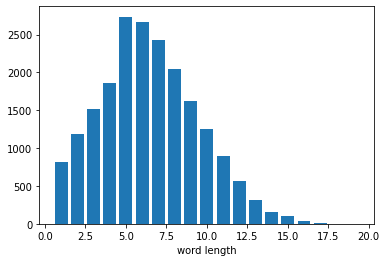

length mean: 6.4644268774703555
length std.: 3.0409295189982215


In [14]:
# sentence length distribution
unique, counts = np.unique(length, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('word length')
plt.show()

# plt.hist(length, bins=length.max())
# plt.xlabel('word length')
# plt.show()

print(f"length mean: {length.mean()}")
print(f"length std.: {length.std()}")

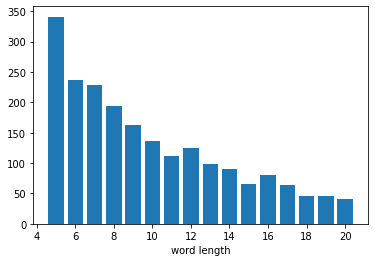

conversation length mean: 9.796708615682478
conversation length std.: 4.206700598078209


In [21]:
# conversation length (number of images) distribution
unique, counts = np.unique(conversation_length, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('word length')
plt.show()

print(f"conversation length mean: {conversation_length.mean()}")
print(f"conversation length std.: {conversation_length.std()}")

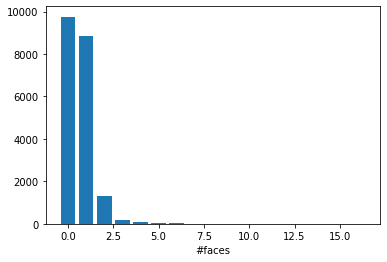

#face mean: 0.6275197628458498
#face std.: 0.7621503115760807


In [22]:
# face number distribution
unique, counts = np.unique(n_face, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('#faces')
plt.show()

# plt.hist(n_face, bins=n_face.max())
# plt.xlabel('#faces')
# plt.show()

print(f"#face mean: {n_face.mean()}")
print(f"#face std.: {n_face.std()}")

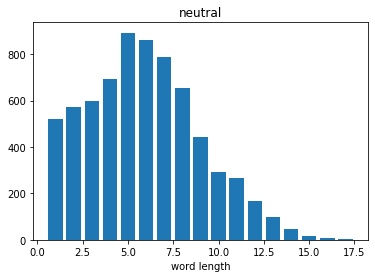

length mean: 5.896706154290667
length std.: 3.0938593145141624



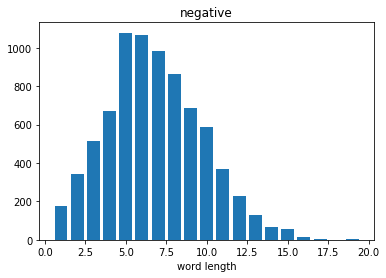

length mean: 6.803190810465859
length std.: 2.956362488163726



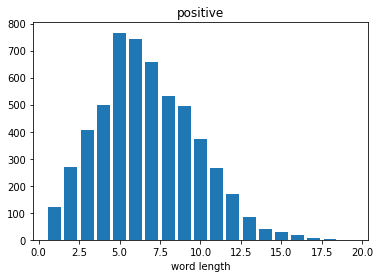

length mean: 6.697063651285792
length std.: 2.98948923899161



In [23]:
# sentiment correlation with conversation length
S = {0:'neutral',1:'negative',2:'positive'}
for i in S.keys():
  temp = length[sentiment==i]

  unique, counts = np.unique(temp, return_counts=True)
  plt.bar(unique, counts)
  plt.title(S[i])
  plt.xlabel('word length')
  plt.show()

  print(f"length mean: {temp.mean()}")
  print(f"length std.: {temp.std()}\n")

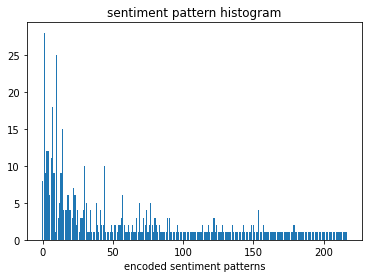

#conversations: 509 
#unique sentiment patterns: 217 
theoritical number of patterns for a conversation with length 6: 96
patterns (sorted from high occurrence to lower):

1
121
101
212
10
12
21
12121
2121
2
102
210
0
1212
1021
2010
21212
20
120121
121212
202
12012
10101
1012
21212121
121021
12101
1020
10121
2120
1010
1201
1202
2020
2102
202020
21210
102101
121012
201
1210
212121
2101
2101212
212102
2021010
101021
21012121
20212121
101212
12121010
1212121
2121202
121020
10212121
121210
202120
1012121
201201
2120121
202021
21202
101010
21012
12020
12102
12120
20202
21010
2012
212101012
101201210
21021
212021
10202
1021202
210201
212010
1021010
212020
10120
1012020
1012012
10102
2021
10212
1010102
1010202
1020212
120
1012010
212101
12021
202101
20212
101020
1201012
101201
101210
21020
102010
102021
102121
120201
12010
120210
20201
20120
20102
121201
20101
202010
101012
1201010
102120201020210201
1201201
212010101
1202120201
1020202101
1012121012
1012120101
1010212121
1010202020
101020201

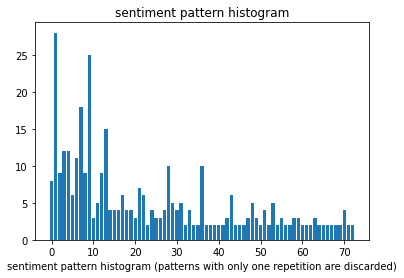

In [45]:
# sentiment temporal pattern

pattern = []
pattern_list = []
for n_conversation in range(len(test_data.img_index)):
    sentiment_pattern = test_data.sentiment[test_data.img_index[n_conversation]]
    temp = np.diff(np.concatenate([[-1], np.array(sentiment_pattern)]))
    temp = sentiment_pattern[temp!=0]
    pattern_list.append(temp)
    pattern.append(np.array([temp[i]*3**i for i in range(len(temp))]).sum()) # we can imagine a string of 0,1,2 numbers (sentiment_pattern) as a base 3 number and convert it to a decimal for easier representation

unique, counts = np.unique(pattern, return_counts=True)
plt.bar(np.arange(len(counts)), counts)
plt.xlabel('encoded sentiment patterns')
plt.title('sentiment pattern histogram')
plt.show()

print('#conversations:', len(pattern), '\n#unique sentiment patterns:', len(set(pattern)), '\ntheoritical number of patterns for a conversation with length 6:', 3*2**5)

temp = unique[np.argsort(counts)][::-1]
print('patterns (sorted from high occurrence to lower):\n')
for i in range(len(counts)):
  print(np.base_repr(temp[i],3))


pattern2 = []
for n_conversation in range(len(test_data.img_index)):
    sentiment_pattern = test_data.sentiment[test_data.img_index[n_conversation]]
    temp = np.diff(np.concatenate([[-1], np.array(sentiment_pattern)]))
    temp = sentiment_pattern[temp!=0]
    pattern2.append(np.array([temp[i]*3**i for i in range(len(temp))]).sum()) # we can imagine a string of 0,1,2 numbers (sentiment_pattern) as a base 3 number and convert it to a decimal for easier representation

unique, counts = np.unique(pattern2, return_counts=True)
plt.bar(np.arange(len(counts[counts>1])), counts[counts>1])
plt.xlabel('sentiment pattern histogram (patterns with only one repetition are discarded)')
plt.title('sentiment pattern histogram')
plt.show()


